# Selección de sectores clave

En este cuaderno se van a definir los criterios de selección de actividades económicas clave para cada provincia.

In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import matplotlib.lines as mlines

In [64]:
import os
path = os.path.join(os.path.expanduser('~'), 'Documents/Proyectos/herramientas/')
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
font_dir = [path + 'Archivo/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
rcParams['font.family'] = 'Archivo'
font_manager.fontManager

In [65]:
fundar_colores_primarios = ['#7BB5C4', '#9FC1AD', '#D3D3E0',  '#8d9bff', '#FF9750', '#FFD900',]
fundar_colores_secundarios = ['#B5E0EA', '#B3B3B3', '#848279', '#AFA36E', '#5D896F', '#9C9CBC', '#E27124']

In [66]:
DATASETS_DIR = './datasets/'
DATAFRAMES_DIR  = './dataframes/'
SERIALIZABLES = './outputs/'

## Lee archivos

In [67]:
with open(SERIALIZABLES + f'relative_density.pkl','rb') as f:
    relative_density_prov = pickle.load(f)

with open(SERIALIZABLES + f'density.pkl','rb') as f:
    density_prov = pickle.load(f)

with open(SERIALIZABLES + f'ica.pkl','rb') as f:
    ica = pickle.load(f)

with open(SERIALIZABLES + f'cog.pkl','rb') as f:
    cog = pickle.load(f)

with open(SERIALIZABLES + f'clae6.pkl','rb') as f:
    ramas = pickle.load(f)

with open(SERIALIZABLES + f'provincias.pkl','rb') as f:
    provincias = pickle.load(f)

with open(SERIALIZABLES + f'RCA.pkl','rb') as f:
    rca = pickle.load(f)

with open(SERIALIZABLES + f'Mpa.pkl','rb') as f:
    Mpa = pickle.load(f)

with open(SERIALIZABLES + f'empleo.pkl','rb') as f:
    empleo = pickle.load(f)

with open(SERIALIZABLES + f'eci.pkl','rb') as f:
    eci = pickle.load(f)

In [68]:
clae_desc = pd.read_excel(DATASETS_DIR + "clae_agg.xlsx")
clae_desc.clae6 = clae_desc.clae6.astype(int).apply(lambda x: f'{x:06}')
clae_desc.head(3)

,clae6,clae6_desc,clae3,clae3_desc,clae2,clae2_desc,letra,letra_desc,letra_desc_mealy
0,014211,"Cría de ganado equino, excepto la realizada en...",14,Cría de animales,1,"Agricultura, ganadería, caza y servicios relac...",A,"Agricultura, Ganadería, y Pesca","Agricultura, Ganadería, y Pesca"
1,011331,Cultivo de hortalizas de hoja y de otras horta...,11,Cultivos temporales,1,"Agricultura, ganadería, caza y servicios relac...",A,"Agricultura, Ganadería, y Pesca","Agricultura, Ganadería, y Pesca"
2,014410,Cría de ganado ovino -excepto en cabañas y par...,14,Cría de animales,1,"Agricultura, ganadería, caza y servicios relac...",A,"Agricultura, Ganadería, y Pesca","Agricultura, Ganadería, y Pesca"


## Crea archivos comunes a cada provincia (fichas estandarizadas)

In [69]:
# Selecciono ponderadores para los criterios clásicos

dens_low = 0.6
cog_low = 0.2
pci_low = 1. - dens_low - cog_low

dens_bal = 0.2
cog_bal = 0.2
pci_bal = 1. - dens_bal - cog_bal

dens_long = 0.2
cog_long = 0.6
pci_long = 1. - dens_long - cog_long

In [70]:
def top_criterios(x, idx_low, idx_bal, idx_long, idx_VCR):
    resultado = ''
    
    if x.name in idx_low:
        resultado += 'Oportunidades cercanas, '
    if x.name in idx_bal:
        resultado += 'Objetivos factibles, '
    if x.name in idx_long:
        resultado += 'Apuestas ambiciosas, '
    if x.name in idx_VCR:
        resultado += 'Trayectoria productiva'
    if resultado[-2:] == ', ':
        resultado = resultado[:-2]
    
    return resultado

In [71]:
# Defino esta función para seleccionar por criterios clásicos

def criterios_atlas(df_temp, criterio):
    
    # Me quedo sólo con los que no tienen RCA para seleccionar sectores
    if df_temp['mcp'] >= 1.:
        return np.nan  
    
    if criterio == 'low_hanging':
        dens_mul, cog_mul, pci_mul = dens_low, cog_low, pci_low
    elif criterio == 'balanced':
        dens_mul, cog_mul, pci_mul = dens_bal, cog_bal, pci_bal
    elif criterio == 'long_jump':
        dens_mul, cog_mul, pci_mul = dens_long, cog_long, pci_long

    index = dens_mul * df_temp['densidad'] + \
            cog_mul * df_temp['relative_cog']  + \
            pci_mul * df_temp['pci']
    
    return index

In [72]:
for prov in range(0, len(provincias)):
    print(provincias[prov])
    data = {'clae6': ramas, 'pci': ica, 'cog': cog[prov], 'densidad': relative_density_prov[prov], 'rca': rca[prov], 'mcp': Mpa[prov], 'empleo_provincial': empleo[prov]}
    variable_name = f'df_{"_".join(provincias[prov].split())}'
    globals()[variable_name] = pd.DataFrame(data).merge(clae_desc[['clae6', 'clae6_desc','letra','letra_desc']])

    globals()[variable_name]['relative_cog'] = globals()[variable_name]['cog'] - globals()[variable_name]['cog'][(1 - globals()[variable_name]['mcp']).astype(bool)].mean()
    globals()[variable_name]['relative_cog']  /= globals()[variable_name]['cog'][(1 - globals()[variable_name]['mcp']).astype(bool)].std()
    globals()[variable_name]['idx_low_hanging'] = globals()[variable_name].apply(lambda x: criterios_atlas(x, 'low_hanging'), axis=1)
    globals()[variable_name]['idx_balanced'] = globals()[variable_name].apply(lambda x: criterios_atlas(x, 'balanced'), axis=1)
    globals()[variable_name]['idx_long_jump'] = globals()[variable_name].apply(lambda x: criterios_atlas(x, 'long_jump'), axis=1)
    
    N_largest = 20
    
    pci_mean = globals()[variable_name].loc[globals()[variable_name]['mcp'] == 1., 'pci'].mean()
    idx_low = globals()[variable_name]['idx_low_hanging'].nlargest(N_largest).index
    idx_bal = globals()[variable_name]['idx_balanced'].nlargest(N_largest).index
    idx_long = globals()[variable_name]['idx_long_jump'].nlargest(N_largest).index
    # Selecciono por Trayectoria: aquellos donde estoy cercano a especializarme
    idx_VCR = globals()[variable_name].loc[(globals()[variable_name]['rca'] < 1.) & (globals()[variable_name]['pci'] > pci_mean), 'rca'].nlargest(N_largest).index
        
    globals()[variable_name][f'Top {N_largest} criterios'] = globals()[variable_name].apply(lambda x: top_criterios(x, idx_low, idx_bal, idx_long, idx_VCR), axis=1)
    globals()[variable_name].drop(columns = {'cog'}, inplace= True)
    #globals()[variable_name].to_excel(f'fichas/df_{provincias[prov]}.xlsx', index= False)

Buenos Aires
Catamarca
Cordoba
Corrientes
Chaco
Chubut
Entre Rios
Formosa
Jujuy
La Pampa
La Rioja
Mendoza
Misiones
Neuquen
Rio Negro
Salta
San Juan
San Luis
Santa Cruz
Santa Fe
Santiago Del Estero
Tucuman
Tierra Del Fuego


## Grafica Diagrama Cercanía-Complejidad

In [73]:
idx_prov = np.where(provincias == 'Cordoba')
idx_prov

(array([2], dtype=int64),)

In [74]:
# Acá pongo el clae6 de aquellos productos seleccionados manualmente a partir del dataframe exportado arriba

oportunidades_cercanas = ['101012','949990','920009','614010','863110','862110','602200','11130','104013','649991','131110','11291','106120','11111','310030','454020','162902','201220','14910','843000']
apuestas = ['951100','139202','631120','181109','352010','329010','239202','202311','780000','143020','239310','275099','812020','661991','854920','651310','643009','139900','182000','202200']
balanceadas = ['931090','741000','281301','321012','602320','722020','301200','651110','649999','639100','151200','581900','329040','466939','201300','203000','692000','432910','259999','202312']
trayectoria = ['107410','282909','107911','267001','611090','477890','243200','477110','772099','472300','477290','662020','272000','561019','222010','854940','854950','101030']

In [75]:
grupos = []
colores_grupos = []

for prod in ramas[(1 - Mpa[idx_prov]).astype(bool)[0]]:
    
    if prod in oportunidades_cercanas:
        grupos.append("Oportunidades cercanas")
        colores_grupos.append('#7BB5C4')

    elif prod in apuestas:
        grupos.append("Apuestas ambiciosas")
        colores_grupos.append('#9FC1AD')    
    
    elif prod in balanceadas:
       grupos.append("Estrategia balanceada")
       colores_grupos.append('#FF9750') 

    elif prod in trayectoria:
        grupos.append("Trayectoria productiva")
        colores_grupos.append('#8d9bff')    
    else:
        grupos.append("Resto")
        colores_grupos.append('#F5F5F5')

kwargs  =   {'edgecolor':"black", 
             'linewidth':0.5 
            }
paleta_grupos = ['#7BB5C4', '#9FC1AD', '#FF9750','#8d9bff'] 

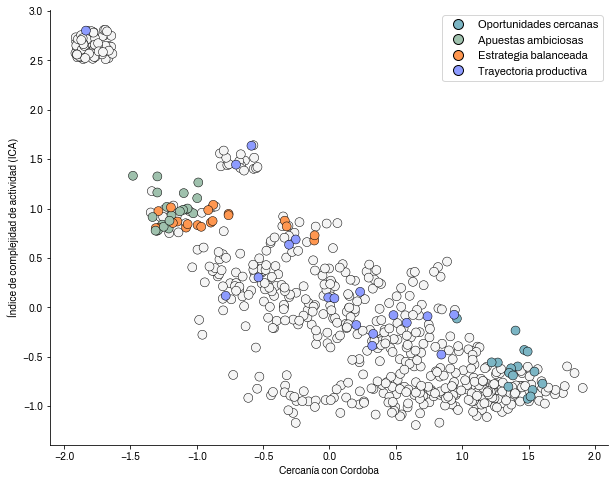

In [76]:
fig, ax = plt.subplots(figsize=(10, 8))
x = relative_density_prov[idx_prov][(1-Mpa[idx_prov]).astype(bool)]
y = ica[(1 - Mpa[idx_prov]).astype(bool)[0]]

jitter_amount = 0.15   # Agrego un jitter para que se vea mejor las actividades que están en el mismo punto

# Creo un dataframe para hacer el plot
desired_groups = ["Oportunidades cercanas", "Apuestas ambiciosas", 'Estrategia balanceada', "Trayectoria productiva"]
desired_groups_df = pd.DataFrame({'x': x, 'y': y, 'grupos': grupos})
desired_groups_df = desired_groups_df[desired_groups_df['grupos'].isin(desired_groups)]
remaining_df = pd.DataFrame({'x': x, 'y': y, 'grupos': grupos})
remaining_df = remaining_df[~remaining_df['grupos'].isin(desired_groups)]

desired_groups_df['x_jittered'] = desired_groups_df['x'] + jitter_amount * (2 * (np.random.rand(len(desired_groups_df['x'])) - 0.5))
desired_groups_df['y_jittered'] = desired_groups_df['y'] + jitter_amount * (2 * (np.random.rand(len(desired_groups_df['y'])) - 0.5))

remaining_df['x_jittered'] = remaining_df['x'] + jitter_amount * (2 * (np.random.rand(len(remaining_df['x'] )) - 0.5))
remaining_df['y_jittered'] = remaining_df['y'] + jitter_amount * (2 * (np.random.rand(len(remaining_df['y'] )) - 0.5))

sns.scatterplot(data=remaining_df, x='x_jittered', y='y_jittered', s=80, hue='grupos', palette=['#F5F5F5'], **kwargs)
sns.scatterplot(data=desired_groups_df, x='x_jittered', y='y_jittered', s=80, hue='grupos', palette=paleta_grupos,  hue_order=desired_groups,**kwargs)
ax.set_xlabel(f'Cercanía con {provincias[idx_prov][0]}')
ax.set_ylabel('Índice de complejidad de actividad (ICA)')
fig.patch.set_facecolor('white')

legend_elements = []
for group in desired_groups:
    color = {"Oportunidades cercanas": '#7BB5C4', "Apuestas ambiciosas": '#9FC1AD', 'Estrategia balanceada': '#FF9750', "Trayectoria productiva": '#8d9bff'}.get(group)
    marker = mlines.Line2D([], [], color=color, marker='o', linestyle='None', markersize=10, markerfacecolor=color, markeredgecolor='black')
    legend_elements.append(marker)

plt.legend(handles=legend_elements, labels=desired_groups, fontsize='11')
sns.despine()